### Logistic regression with gradient descent 

Code adapted from https://github.com/drbilo/logistic-regression

Look at iris_test.ipynb for demo on how the functions were used for the iris dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

In [2]:
def sigmoid(z):
    return  1 / (1 + np.exp(-z))

def cost(h, y):
    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

def gradient(X, h, y):
    return np.dot(X.T, (h - y)) / y.shape[0]

def logistic_regression(X, y, theta, alpha, iters):
    cost_array = np.zeros(iters)
    for i in range(iters):
        h = sigmoid(np.dot(X, theta))
        cost_num = cost(h, y)
        cost_array[i] = cost_num
        gradient_val = gradient(X, h, y)
        theta = theta - (gradient_val * alpha)
    return theta, cost_array

def plotChart(iterations, cost_num):
    fig, ax = plt.subplots()
    ax.plot(np.arange(iterations), cost_num, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title('Error vs Iterations')
    plt.style.use('fivethirtyeight')
    plt.show()

#### Data cleaning

In [3]:
# import data into a pandas dataframe
df = pd.read_csv('telco_customer_churn.csv')

df.head()

,customer_ID,gender,senior_citizen,partner,dependents,tenure,phone_Service,multiple_lines,internet,security_online,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type,paperless_billing,payment_mode,charges_per_month,charges_total,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Reassign dtypes
df["customer_ID"] = df["customer_ID"].astype("string")
df["gender"] = df["gender"].astype("category")
df["senior_citizen"] = df["senior_citizen"].astype("category")
df["partner"] = df["partner"].astype("category")
df["dependents"] = df["dependents"].astype("category")
df["tenure"] = df["tenure"].astype(int)
df["phone_Service"] = df["phone_Service"].astype("category")
df["multiple_lines"] = df["multiple_lines"].astype("category")
df["internet"] = df["internet"].astype("category")
df["security_online"] = df["security_online"].astype("category")
df["backup_online"] = df["backup_online"].astype("category")
df["device_protection"] = df["device_protection"].astype("category")
df["tech_support"] = df["tech_support"].astype("category")
df["streaming_tv"] = df["streaming_tv"].astype("category")
df["streaming_movies"] = df["streaming_movies"].astype("category")
df["contract_type"] = df["contract_type"].astype("category")
df["paperless_billing"] = df["paperless_billing"].astype("category")
df["payment_mode"] = df["payment_mode"].astype("category")
df["churn"] = df["churn"].astype("category")

In [5]:
# Check number of blank strings
print((df["charges_total"] == "").sum())

# Replace blank strings with NA, some string could be "  " and not just "", so we also strip whitespaces.
df["charges_total"] = df["charges_total"].apply(lambda s: s.strip())
df["charges_total"] = df["charges_total"].replace("", np.nan)

0


In [6]:
# Convert to the float dtype
df["charges_total"] = df["charges_total"].astype(float)

In [7]:
# Standardise to Yes / No for senior citizen
df["senior_citizen"] = df["senior_citizen"].apply(lambda x: "Yes" if x == 1 else "No")
df["senior_citizen"] = df["senior_citizen"].astype("category")

In [8]:
# Drop NAs
df.isna().sum()

customer_ID           0
gender                0
senior_citizen        0
partner               0
dependents            0
tenure                0
phone_Service         0
multiple_lines        0
internet              0
security_online       0
backup_online         0
device_protection     0
tech_support          0
streaming_tv          0
streaming_movies      0
contract_type         0
paperless_billing     0
payment_mode          0
charges_per_month     0
charges_total        11
churn                 0
dtype: int64

In [9]:
df = df.dropna()

#### Feature engineering - OneHotEnoding of categorical variables

In [10]:
# Drop churn and customer id
x = df.drop(["customer_ID", "churn"], axis = 1)

# Choose columns that are categorical
cat_vars = x.select_dtypes(include=['category'])

# Onehotencode categorical variables
x_dummies = pd.get_dummies(cat_vars)

# Return the remainder of non-categorical variables and then concatenate with the ohe features
non_cat_vars = x[x.columns.difference(cat_vars.columns)]

### Try predicting with non categorical variables first

In [11]:
# Scale non-categorical vars
scaler = StandardScaler()
x = scaler.fit_transform(non_cat_vars)

y = df["churn"].apply(lambda x: 1 if x == "Yes" else 0)
y = y.astype(int)

In [12]:
# Scikit learn implementation just to check
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
lr_model = LogisticRegression(random_state=0, solver = "saga")
lr_model = lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)
print(y_pred)

[0 0 0 ... 1 0 0]


In [13]:
# add 1 column to allow vectorized calculations
x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)

# Initial theta values
theta = np.zeros(x.shape[1])

# Starting values
h = sigmoid(np.dot(x, theta))
print("Initial cost value for theta values {0} is: {1}".format(theta, cost(h,y)))

Initial cost value for theta values [0. 0. 0. 0.] is: 0.6931471805599454


In [14]:
# define hyperparameters
alpha = 0.1
iterations = 10000

# run logistic regression
theta, cost_num = logistic_regression(x, y, theta, alpha, iterations)

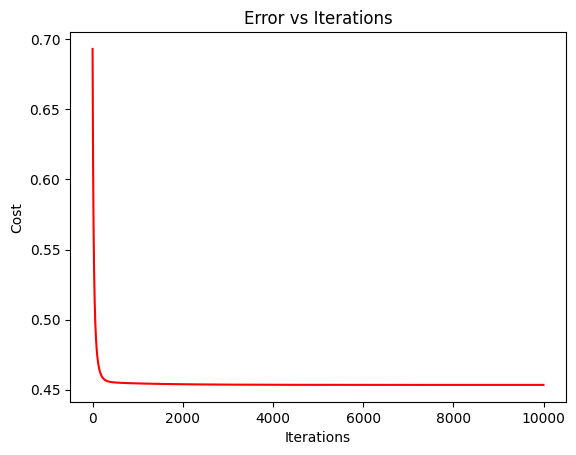

In [15]:
# display cost chart
plotChart(iterations, cost_num)

In [25]:
# final values
h = sigmoid(np.dot(x, theta))
print("Final cost value for theta values {0} is: {1}".format(theta, cost(h,y)))

Final cost value for theta values [-1.48379088  0.91227849  0.31213885 -1.63123419] is: 0.4533732166953244


### Predict for categorical and non-categorical variables

In [ ]:
# Feature engineering with continuous and other categorical data
x = non_cat_vars.join(x_dummies)
x.head()